# Create a GeoDataFrame for the particle tracking output

In [2]:
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Function to extract latitude and longitude from a NetCDF file
def extract_lat_lon(nc_file):
    with nc.Dataset(nc_file) as dataset:
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
    return latitude, longitude

# Path to the directory containing your NetCDF files
data_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata/202306/endpoint/'

In [3]:

# Get a list of all NetCDF files in the directory
nc_files = [f for f in os.listdir(data_dir) if f.endswith('.nc')]

# create an empty DataFrame
df = pd.DataFrame()

# Iterate through each NetCDF file and save latitude and longitude in separate columns
for nc_file in sorted(filter(lambda x: x.endswith("nc"), os.listdir(data_dir)), key=lambda x: int(x.split(".")[0].split("_")[1])):
    file_path = os.path.join(data_dir, nc_file)
    latitude, longitude = extract_lat_lon(file_path)

    # Flatten latitude and longitude arrays
    latitude = latitude.flatten()
    longitude = longitude.flatten()

    # Create a DataFrame with 'Latitude' and 'Longitude' columns
    file_df = pd.DataFrame({'Latitude': latitude, 'Longitude': longitude})

    # Add a column for the file name
    file_df['File'] = nc_file

    # Append the DataFrame to the result DataFrame
    df = pd.concat([df, file_df], ignore_index=True)





In [4]:
# Specify the index of the point you want to delete
new_Longitude = 275.28153992
condition = (df['Longitude'] == -82.422523)
# Update the values based on the condition
df.loc[condition, 'Longitude'] = new_Longitude
print(df)

         Latitude   Longitude          File
0       45.780148  275.276215    pylag_1.nc
1       45.765518  275.279755    pylag_1.nc
2       45.744976  275.333862    pylag_1.nc
3       45.742695  275.350555    pylag_1.nc
4       45.718945  275.401306    pylag_1.nc
...           ...         ...           ...
135247  43.013428  277.575256  pylag_100.nc
135248  43.013588  277.575195  pylag_100.nc
135249  43.008484  275.281540  pylag_100.nc
135250  43.016834  277.573456  pylag_100.nc
135251  43.007092  277.578278  pylag_100.nc

[135252 rows x 3 columns]


/tmp/ipykernel_634743/929974116.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '275.28153992' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[condition, 'Longitude'] = new_Longitude


In [5]:
# Create a GeoDataFrame from the DataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf_crs = "EPSG:4326"
gdf.set_crs = gdf_crs 
# Display the GeoDataFrame
print("GeoDataFrame:")
print(gdf)

GeoDataFrame:
         Latitude   Longitude          File                geometry
0       45.780148  275.276215    pylag_1.nc  POINT (275.276 45.780)
1       45.765518  275.279755    pylag_1.nc  POINT (275.280 45.766)
2       45.744976  275.333862    pylag_1.nc  POINT (275.334 45.745)
3       45.742695  275.350555    pylag_1.nc  POINT (275.351 45.743)
4       45.718945  275.401306    pylag_1.nc  POINT (275.401 45.719)
...           ...         ...           ...                     ...
135247  43.013428  277.575256  pylag_100.nc  POINT (277.575 43.013)
135248  43.013588  277.575195  pylag_100.nc  POINT (277.575 43.014)
135249  43.008484  275.281540  pylag_100.nc  POINT (275.282 43.008)
135250  43.016834  277.573456  pylag_100.nc  POINT (277.573 43.017)
135251  43.007092  277.578278  pylag_100.nc  POINT (277.578 43.007)

[135252 rows x 4 columns]


(42.0, 46.3)

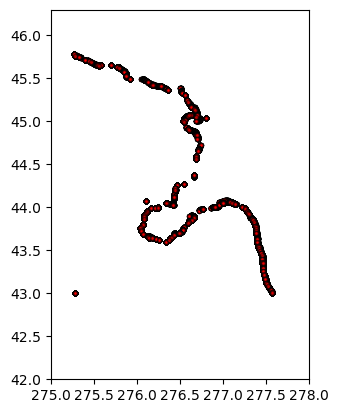

In [6]:
xmin,xmax,ymin,ymax = 275, 278, 42, 46.3
ax = gdf.plot(markersize=8, color='red', alpha=0.5, edgecolor='black')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


In [7]:
# Reading the intersection file for the watershed and lake

fp = "/home/samin/data/shapefiles/intersectionpoints/GLB_Bdry_buff10km__lh_shore_NOAA_70k_Intersect_snaped.shp"
data = gpd.read_file(fp)
# Rename col 0 to lon and col 1 to lat
data.rename(columns={"POINT_X":"Longitude", "POINT_Y":"Latitude"}, inplace=True)
data["Longitude"] = data["Longitude"] % 360
data = data.set_crs('epsg:4326',allow_override=True)
#print(data)
print(data['Latitude'], data['Longitude'])

0      45.780149
1      45.765519
2      45.744976
3      45.742696
4      45.718945
         ...    
229    43.039771
230    43.038346
231    43.031368
232    43.025005
233    43.008666
Name: Latitude, Length: 234, dtype: float64 0      275.276222
1      275.279741
2      275.333867
3      275.350543
4      275.401315
          ...    
229    277.557899
230    277.558956
231    277.563695
232    277.568079
233    277.577755
Name: Longitude, Length: 234, dtype: float64


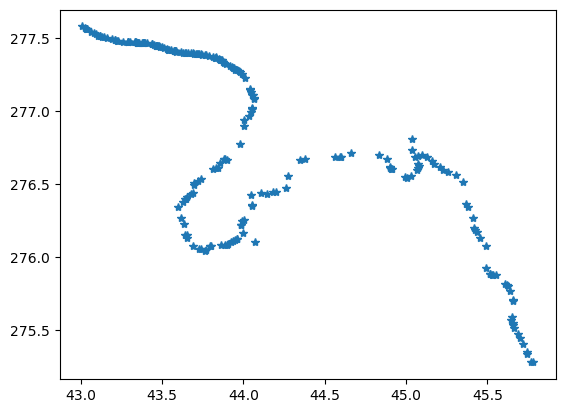

In [8]:
plt.plot(data['Latitude'], data['Longitude'],'*')

In [9]:
# Create Point geometries for each point in both GeoDataFrames
geometry_gdf = [Point(lon, lat) for lon, lat in zip(gdf['Longitude'], gdf['Latitude'])]
geometry_data = [Point(lon, lat) for lon, lat in zip(data['Longitude'], data['Latitude'])]

# Create GeoDataFrames with Point geometries
gdf_points = gpd.GeoDataFrame(gdf, geometry=geometry_gdf)
data_points = gpd.GeoDataFrame(data, geometry=geometry_data)


gdf_points.crs = 'epsg:4326'
data_points.crs = 'epsg:4326'

#intersection_result = gpd.sjoin(gdf_points, data_points)
# Check if spatial index exists
if gdf_points.sindex.is_empty:
    gdf_points.sindex = gdf_points.sindex.intersection(gdf_points.geometry)

# Perform spatial intersection
result = gpd.sjoin(gdf_points, gdf_points,how="inner", predicate="intersects")
# Display the result
print("Number of points from gdf_points that intersect with data_points:", len(result))
print(result)

: 

In [1]:
import matplotlib.pyplot as plt

# Plot gdf_points
ax1 = gdf_points.plot(markersize=10, color='red', alpha=0.5, edgecolor='red', label='PT end points')
xmin,xmax,ymin,ymax = 275, 277.69, 43, 46.3
# Plot data_points on the same plot
data_points.plot(ax=ax1, markersize=15, color='blue', alpha=0.5, edgecolor='blue', label='CW location')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
# Add labels, legend, etc.
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Comparison of particle tracking path and watersheds')
plt.legend()
plt.show()


NameError: name 'gdf_points' is not defined

In [11]:
# Round coordinate values to 5 decimal places (adjust as needed)
gdf_points['Latitude'] = gdf_points['Latitude'].round(5)
gdf_points['Longitude'] = gdf_points['Longitude'].round(5)

data_points['Latitude'] = data_points['Latitude'].round(5)
data_points['Longitude'] = data_points['Longitude'].round(5)

# Perform spatial join after rounding coordinates
intersection_result = gpd.sjoin(gdf_points, data_points, predicate="intersects")
# Display the result
print("Number of points from gdf_points that intersect with data_points:", len(intersection_result))
print(intersection_result)

Number of points from gdf_points that intersect with data_points: 0
Empty GeoDataFrame
Columns: [Latitude_left, Longitude_left, File, geometry, index_right, FID_GLB_Bd, arcid, grid_code, from_node, to_node, FID_lh_sho, LENGTH, S_SCALE, REV_DATE, Longitude_right, Latitude_right, Watershed_]
Index: []


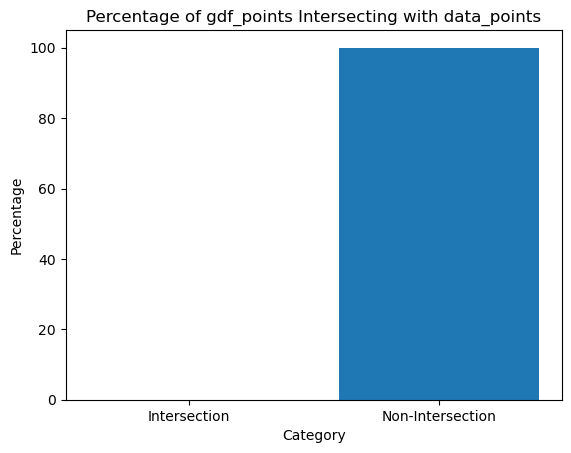

In [12]:
import matplotlib.pyplot as plt

 #Calculate the percentage of intersecting points
percentage_intersection = (len(intersection_result) / len(gdf_points) )* 100
percentage_non_intersection = 100 - percentage_intersection

# Plot a histogram
plt.bar(['Intersection', 'Non-Intersection'], [percentage_intersection, percentage_non_intersection])
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of gdf_points Intersecting with data_points')
plt.show()


